<a href="https://colab.research.google.com/github/ShyamMuralidharan/AUG-CV-1/blob/master/Pneumonia_Detection_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIML Online Capstone - Pneumonia Detection Challenge**

**Acknowledgment for the datasets** 

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements

# **Project By**
Sailesh , Karthik, Krishna Kumar

# **Get Required Files from Drive**

In [ ]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 84kB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dicom
from pydicom.data import get_testdata_files
import cv2
from zipfile import ZipFile
import os
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
rootDir = '/content/drive/My Drive/Project_Pneumonia_Detection/'

# **File Details :**
stage_2_detailed_class_info.csv

stage_2_test_images.zip

stage_2_train_images.zip

stage_2_train_labels.csv

In [ ]:
class_info = (rootDir + 'stage_2_detailed_class_info.csv')
train_info = (rootDir + 'stage_2_train_labels.csv')

In [ ]:
test_image = (rootDir + 'stage_2_test_images.zip')
train_image =(rootDir + 'stage_2_train_images.zip')

**Reading and Exploring Data**

In [ ]:
#import pandas as pd
cinfo = pd.read_csv(class_info)
tinfo = pd.read_csv(train_info)

In [ ]:
cinfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,000924cf-0f8d-42bd-9158-1af53881a557,Normal
2,000db696-cf54-4385-b10b-6b16fbb3f985,Lung Opacity
3,000fe35a-2649-43d4-b027-e67796d412e0,Lung Opacity
4,001031d9-f904-4a23-b3e5-2c088acd19c6,Lung Opacity


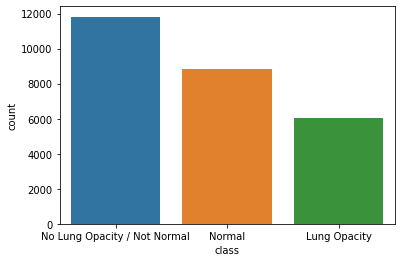

In [ ]:
sns.countplot('class',data=cinfo)

The plot on class shows the split among the different classes of data namely No Lung Opacity / Not Normal , Normal & Lung Opacity

*   ~6000 Lung Opacity class
*   ~8500 Normal class
*   ~12000 No Lung Opacity / Not Normal Class

The distribution of class is biased towards No Lung Opacity / Not Normal & Normal Class


In [ ]:
tinfo.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1


In [ ]:
rslt_df = tinfo.loc[tinfo['Target'] != 0] 

In [ ]:
rslt_df

,patientId,x,y,width,height,Target
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1
5,000fe35a-2649-43d4-b027-e67796d412e0,83.0,227.0,296.0,438.0,1
6,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,1
...,...,...,...,...,...,...
30204,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,157.0,393.0,237.0,458.0,1
30205,ffd787b6-59ca-48cb-bd15-bcedd52cf37c,571.0,238.0,286.0,482.0,1
30217,fff0b503-72a5-446a-843d-f3d152e39053,158.0,267.0,180.0,209.0,1
30221,fffb2395-8edd-4954-8a89-ffe2fd329be3,177.0,285.0,225.0,529.0,1


# **Target Distribution**

The target data contains 30227 rows with 26684 unique patient id. There are 9555 rows with pneumonia positive. Out of the 6012 pneumonia positive cases 2614 patients have one of the lung infected. 3266 patients have at have 2 infection. 119 patients have at have 3 infection and 13 have 4 infections.

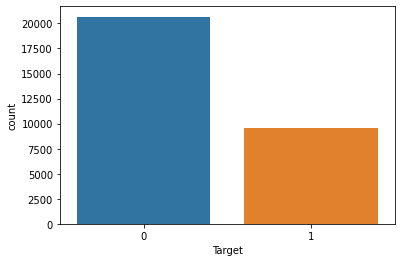

In [ ]:
sns.countplot('Target',data=tinfo)

The plot Target class shows if the patient has Pneumonia or not

*   ~9500 with Pneumonia
*   ~20000 without Pneumonia

The distribution of Target is biased towards Non Pneumonia cases


In [ ]:
cinfo.info()
tinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 417.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


We have ~ 9555 recods for pneumonia positive

# Combining two tables


In [ ]:
result = pd.concat([cinfo,tinfo], axis=1, sort=False)
#result = cinfo.append(tinfo)
#frames = [cinfo, tinfo]
#result = pd.concat(frames)

In [ ]:
result.head()

,patientId,class,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,000924cf-0f8d-42bd-9158-1af53881a557,Normal,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,Lung Opacity,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
3,000fe35a-2649-43d4-b027-e67796d412e0,Lung Opacity,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,Lung Opacity,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1


After combining the class and target it can be observed that the Lung Opacity cases are Pneumonia positive / true cases other cases are non Pneumonia cases

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  26684 non-null  object 
 1   class      26684 non-null  object 
 2   patientId  30227 non-null  object 
 3   x          9555 non-null   float64
 4   y          9555 non-null   float64
 5   width      9555 non-null   float64
 6   height     9555 non-null   float64
 7   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.8+ MB


# Extracting DICOM files for reading

In [ ]:
from zipfile import ZipFile
file_name = train_image
with ZipFile(file_name, 'r') as zip:
  zip.printdir()
  print('Extracting all the files now...')
  zip.extractall()
  print('Done!')

Streaming output truncated to the last 5000 lines.
d525eafb-8908-45fd-a942-48d07c435487.dcm       2019-12-11 23:52:58       185484
d5265640-17db-4880-866d-d2952e32941c.dcm       2019-12-11 23:52:58       143960
d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm       2019-12-11 23:52:58       114994
d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm       2019-12-11 23:52:58       107196
d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm       2019-12-11 23:52:58       120554
d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm       2019-12-11 23:52:58       117406
d52ce67b-be7c-4349-8dc4-38562928d208.dcm       2019-12-11 23:52:58       118880
d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm       2019-12-11 23:52:58       142256
d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm       2019-12-11 23:52:58       120310
d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm       2019-12-11 23:52:58       172814
d539e101-5662-445c-9f6a-381e674f0aed.dcm       2019-12-11 23:52:58       154548
d53cee27-787e-4136-aaf6-03bcff985ac9.dcm       2019-12-11 23:52:58   

# **Read  & Extract metadata from dcm file using dicom**

Sample extraction

In [ ]:
s_file = "0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm"
file_name=(train_image + "/" +s_file)
print(file_name)

/content/drive/My Drive/Project_Pneumonia_Detection/stage_2_train_images.zip/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


In [ ]:
#s_file = '0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'
s_file ='00436515-870c-4b36-a041-de91049b9ab4.dcm'
file_name=(train_image + "/" +s_file)
with ZipFile(train_image, 'r') as zip:
  print('Extracting all the files now...')
  zext_file= zip.extract(s_file)
  dcm_data = dicom.dcmread(zext_file)
  print('Done!') 

Extracting all the files now...
Done!


In [ ]:
dcm_data = dicom.read_file("0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm")

In [ ]:
print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
dcm_data.values()

dict_values([(0008, 0005) Specific Character Set              CS: 'ISO_IR 100', (0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage, (0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526, (0008, 0020) Study Date                          DA: '19010101', (0008, 0030) Study Time                          TM: '000000.00', (0008, 0050) Accession Number                    SH: '', (0008, 0060) Modality                            CS: 'CR', (0008, 0064) Conversion Type                     CS: 'WSD', (0008, 0090) Referring Physician's Name          PN: '', (0008, 103e) Series Description                  LO: 'view: PA', (0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6', (0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6', (0010, 0030) Patient's Birth Date                DA: '', (0010, 0040) Patient's Sex                       CS:

In [ ]:
dcm_df= dcm_data.PatientID,dcm_data.PatientSex,dcm_data.PatientAge,dcm_data.BodyPartExamined

In [ ]:
dcm_df

('0004cfab-14fd-4e49-80ba-63a80b6bddd6', 'F', '51', 'CHEST')

In [ ]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


# Print Sample image

In [ ]:
# Defining the BW style for the image
plt.style.use('seaborn-whitegrid')

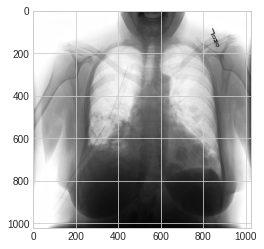

In [ ]:
plt.imshow(dcm_data.pixel_array)

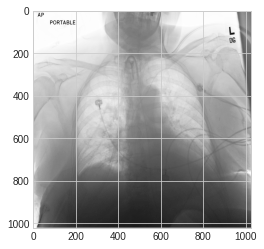

In [ ]:
#ds= "00aecb01-a116-45a2-956c-08d2fa55433f.dcm"
ds= "c1f7889a-9ea9-4acb-b64c-b737c929599a.dcm"
plt.imshow(dicom.read_file(ds).pixel_array)

Extract metadat from dcm file

In [ ]:
t=open(rootDir+"/"+'metadata_train.txt','w')
s='patientid'+','+'dob'+','+'gender'+','+'age'+','+'bodypart'+','+'viewposition'+','+'rows'+ ',' + 'columns'
t.write(s)
t.close()
with ZipFile('/content/drive/My Drive/Project_Pneumonia_Detection/stage_2_train_images.zip', 'r') as f:
  for name in tqdm(f.namelist()):
    #print(name)
    x=f.extract(name)
    dataset = dicom.dcmread(x)
    t=open('/content/drive/My Drive/Project_Pneumonia_Detection/metadata_train.txt','a')
    s=str(dataset.PatientID)+',' + str(dataset.PatientBirthDate) +',' + str(dataset.PatientSex)+','+ str(dataset.PatientAge) + ',' + str(dataset.BodyPartExamined) + ',' + str(dataset.ViewPosition) + ',' + str(dataset.Rows) + ',' + str(dataset.Columns)
    #print(s)
    t.write('\n' + s)
    t.close()

100%|██████████| 26684/26684 [03:35<00:00, 123.60it/s]


Fetch data from multiple files and append it to the data frame

In [ ]:
meta_info = (rootDir + 'metadata_train.csv')

In [ ]:
minfo = pd.read_csv(meta_info)

In [ ]:
minfo.head()

,patientid,dob,gender,age,bodypart,viewposition,rows,columns,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,F,51,CHEST,PA,1024,1024,0
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,F,19,CHEST,AP,1024,1024,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,NaN,F,25,CHEST,AP,1024,1024,1
3,000fe35a-2649-43d4-b027-e67796d412e0,NaN,M,40,CHEST,AP,1024,1024,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,NaN,M,57,CHEST,PA,1024,1024,1


Date of birth represented as dob is blan and can be dropped

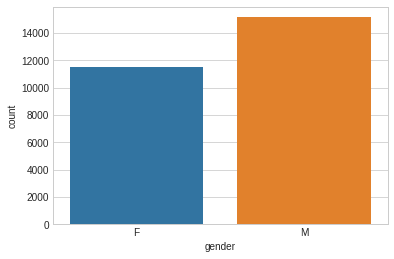

In [ ]:
sns.countplot('gender',data=minfo)

From the gender distribution plot it can be noted thete the data is biased with more male records

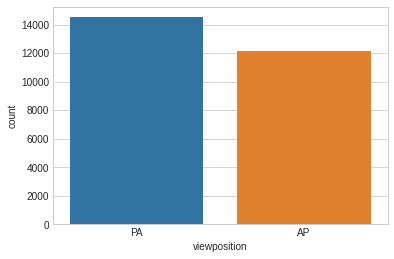

In [ ]:
sns.countplot('viewposition',data=minfo)

The plot on the position shows there are more PA position images compared to the AP

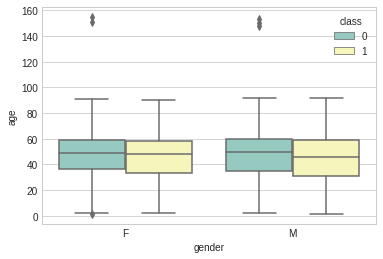

In [ ]:
ax = sns.boxplot(x="gender", y="age", hue="class", data=minfo, palette="Set3")

Plot on the age and sex shows the age distribution is between late 30's and 60 for both male and female  

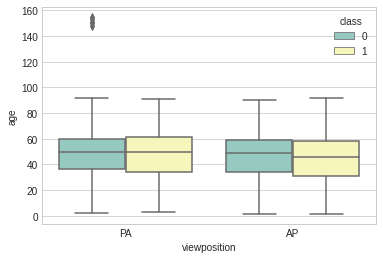

In [ ]:
ax = sns.boxplot(x="viewposition", y="age", hue="class", data=minfo, palette="Set3")

From the plot , there is equal proportion of split between pneumonic and non-pneumonic on the position (AP - Anterior to Posterior or PA - Posterior to Anterior) though the targed is biased (pneumonic and non-pneumonic)

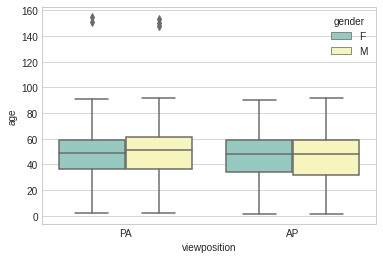

In [ ]:
ax = sns.boxplot(x="viewposition", y="age", hue="gender", data=minfo, palette="Set3")

From the plot , there is equal proportion of split between male and female on the position (AP - Anterior to Posterior or PA - Posterior to Anterior)